# Bring Packages

In [320]:
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [321]:
# Load data
print("Loading training data...")
X_train = np.load("data_train.npy")  
print("Training data loaded.")
# shape: (num_documents, num_terms)
print("Loading training labels...")
y_train = np.loadtxt('label_train.csv',skiprows=1,delimiter=',')  # shape: (num_documents,)
print("Training labels loaded.")
print("Loading test data...")
X_test = np.load("data_test.npy")  # shape: (num_test_documents, num_terms)
print("Test data loaded.")
print("Loading vocabulary...")
vocab_data = np.load("vocab_map.npy", allow_pickle=True)
print("Vocab data loaded.")

# Check dimensions
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Vocab data shape: {vocab_data.shape}")



Loading training data...
Training data loaded.
Loading training labels...
Training labels loaded.
Loading test data...
Test data loaded.
Loading vocabulary...
Vocab data loaded.
Training data shape: (9422, 26354)
Training labels shape: (9422, 2)
Test data shape: (2356, 26354)
Vocab data shape: (26354,)


In [322]:
def testdf(df):
    if isinstance(df, pd.DataFrame):
        print("The object is a DataFrame.")
    else:
        print("The object is not a DataFrame.")

def test_if_list(obj):
    if isinstance(obj, list):
        print("The object is a list.")
    else:
        print("The object is not a list.")

def test_if_tuple(obj):
    if isinstance(obj, tuple):
        print("The object is a tuple.")
    else:
        print("The object is not a tuple.")

def test_if_array(obj):
    if isinstance(obj, np.ndarray):
        print("The object is a numpy array.")
    else:
        print("The object is not a numpy array.")

# Model

In [323]:
def compute_class_weights(y):
    classes, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_weights = {cls: total_samples / (len(classes) * count) for cls, count in zip(classes, counts)}
    return class_weights

def weighted_binary_cross_entropy(y_true, y_pred, class_weights):
    epsilon = 1e-15  # To avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    weights = np.vectorize(class_weights.get)(y_true)
    loss = -np.mean(weights * (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)))
    return loss

In [324]:
class GaussianMaxLikelihood:
    def __init__(self, n_dims):
        self.n_dims = n_dims
        self.mu = np.zeros(n_dims)
        # We only save a scalar standard deviation because our model is the isotropic Gaussian
        self.sigma_sq = 1.0

    # For a training set, the function should compute the ML estimator of the mean and the variance
    def train(self, train_data,weights = None):
        # Here, you have to find the mean and variance of the train_data data and put it in self.mu and self.sigma_sq
        ### Using the expressions derived above
        if weights is None:
            weights = np.ones(train_data.shape[0])
        self.mu = np.average(train_data, axis=0, weights=weights)
        self.sigma_sq = np.average((train_data - self.mu) ** 2.0, axis=0, weights=weights).mean()


    # Returns a vector of size nb. of test ex. containing the log probabilities of each test example under the model.
    # exemple test
    def loglikelihood(self, test_data):
        ### a is the log of the first term (1/(sigma sqrt(2pi))) in the isotropic probability distribution in the image above
        ### We are using log(ab) = log(a)+log(b) where a is 1/(sigma sqrt(2pi)) and b is exp(-||x-mu||^2/(2*sigma^2)). Again see the image above.
        a = self.n_dims * -(np.log(np.sqrt(self.sigma_sq)) + (1 / 2) * np.log(2 * np.pi))
        log_prob = a - np.sum((test_data - self.mu) ** 2.0, axis=1) / (2.0 * self.sigma_sq)
        return log_prob


In [325]:
class BayesClassifier:
    def __init__(self, maximum_likelihood_models, priors):
        self.maximum_likelihood_models = maximum_likelihood_models ### a list of multi-variate MaxLikelihoodGaussians for each class
        self.priors = priors
        if len(self.maximum_likelihood_models) != len(self.priors):
            print('The number of ML models must be equal to the number of priors!')
        self.n_classes = len(self.maximum_likelihood_models)

    # Returns a matrix of size number of test ex. times number of classes containing the log
    # probabilities of each test example under each model, trained by ML.
    def loglikelihood(self, test_data):

        log_pred = np.zeros((test_data.shape[0], self.n_classes))

        for i in range(self.n_classes):
            # Here, we will have to use maximum_likelihood_models[i] and priors to fill in for each class
            # each column of log_pred (it's more efficient to do a entire column at a time)
            log_pred[:, i] = self.maximum_likelihood_models[i].loglikelihood(test_data) + np.log(self.priors[i])

        return log_pred

# Data Cleaning

In [326]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique,counts)

[0.000e+00 1.000e+00 2.000e+00 ... 9.419e+03 9.420e+03 9.421e+03] [7125 2299    1 ...    1    1    1]


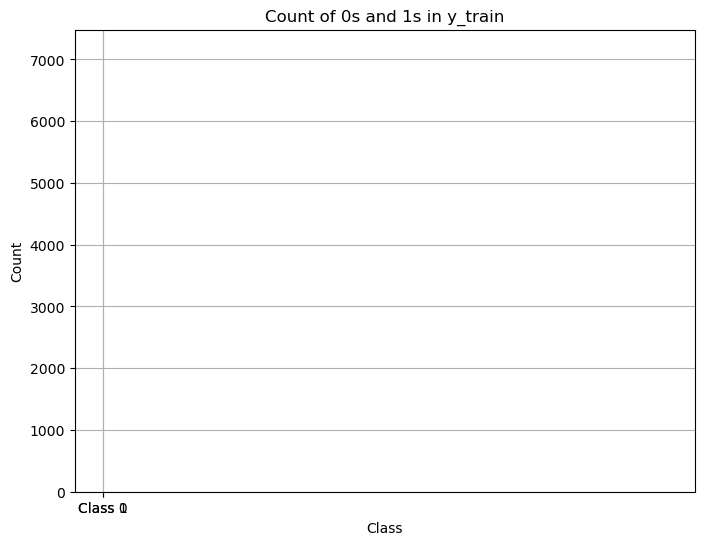

In [327]:
# Count the occurrences of 0s and 1s
unique, counts = np.unique(y_train, return_counts=True)
count_dict = dict(zip(unique, counts))

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(count_dict.keys(), count_dict.values(), color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of 0s and 1s in y_train')
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.grid(True)
plt.show()



In [328]:
def print_class_percentages(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    percentages = {cls: (count / total) * 100 for cls, count in zip(unique, counts)}
    
    print(f"Class percentages for {dataset_name}:")
    for cls, percentage in percentages.items():
        print(f"Class {cls}: {percentage:.2f}%")

# Print class percentages for training and test datasets
print_class_percentages(y_train, "Training Dataset")


Class percentages for Training Dataset:
Class 0.0: 75.62%
Class 1.0: 24.40%
Class 2.0: 0.01%
Class 3.0: 0.01%
Class 4.0: 0.01%
Class 5.0: 0.01%
Class 6.0: 0.01%
Class 7.0: 0.01%
Class 8.0: 0.01%
Class 9.0: 0.01%
Class 10.0: 0.01%
Class 11.0: 0.01%
Class 12.0: 0.01%
Class 13.0: 0.01%
Class 14.0: 0.01%
Class 15.0: 0.01%
Class 16.0: 0.01%
Class 17.0: 0.01%
Class 18.0: 0.01%
Class 19.0: 0.01%
Class 20.0: 0.01%
Class 21.0: 0.01%
Class 22.0: 0.01%
Class 23.0: 0.01%
Class 24.0: 0.01%
Class 25.0: 0.01%
Class 26.0: 0.01%
Class 27.0: 0.01%
Class 28.0: 0.01%
Class 29.0: 0.01%
Class 30.0: 0.01%
Class 31.0: 0.01%
Class 32.0: 0.01%
Class 33.0: 0.01%
Class 34.0: 0.01%
Class 35.0: 0.01%
Class 36.0: 0.01%
Class 37.0: 0.01%
Class 38.0: 0.01%
Class 39.0: 0.01%
Class 40.0: 0.01%
Class 41.0: 0.01%
Class 42.0: 0.01%
Class 43.0: 0.01%
Class 44.0: 0.01%
Class 45.0: 0.01%
Class 46.0: 0.01%
Class 47.0: 0.01%
Class 48.0: 0.01%
Class 49.0: 0.01%
Class 50.0: 0.01%
Class 51.0: 0.01%
Class 52.0: 0.01%
Class 53.0: 0.

## See on average how often does a word appear in text

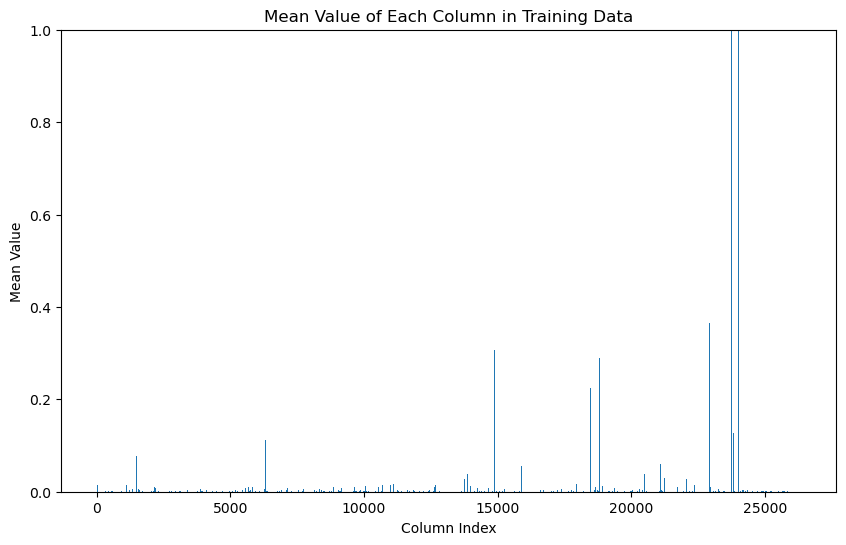

In [329]:
column_means = np.mean(X_train, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 1)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

In [330]:
# Calculate the mean of each column
column_means = np.mean(X_train, axis=0)

# Calculate the frequency of non-zero values in each column
non_zero_frequencies = np.count_nonzero(X_train, axis=0) / X_train.shape[0]

# Define the criteria
mean_threshold = 0.1
frequency_threshold = 0.1

# Filter columns based on the criteria
columns_to_keep = (column_means >= mean_threshold) & (non_zero_frequencies >= frequency_threshold)
X_train_filtered = X_train[:, columns_to_keep]

print(columns_to_keep)

[False False False ... False False False]


In [331]:
vocab_data[columns_to_keep]

array(['accuracy', 'algorithm', 'algorithms', 'all', 'also', 'an',
       'analysis', 'and', 'applications', 'approach', 'approaches', 'are',
       'art', 'as', 'at', 'based', 'be', 'been', 'better', 'between',
       'both', 'but', 'by', 'can', 'classification', 'data', 'datasets',
       'deep', 'demonstrate', 'different', 'each', 'efficient',
       'existing', 'experiments', 'features', 'first', 'for', 'framework',
       'from', 'given', 'has', 'have', 'high', 'how', 'however', 'in',
       'information', 'into', 'is', 'it', 'its', 'knowledge', 'language',
       'large', 'learning', 'machine', 'many', 'method', 'methods',
       'model', 'models', 'more', 'most', 'network', 'networks', 'neural',
       'new', 'non', 'not', 'novel', 'number', 'of', 'on', 'one', 'only',
       'or', 'order', 'other', 'our', 'over', 'paper', 'performance',
       'present', 'problem', 'problems', 'propose', 'proposed', 'provide',
       'real', 'results', 'set', 'several', 'show', 'some', 'state',


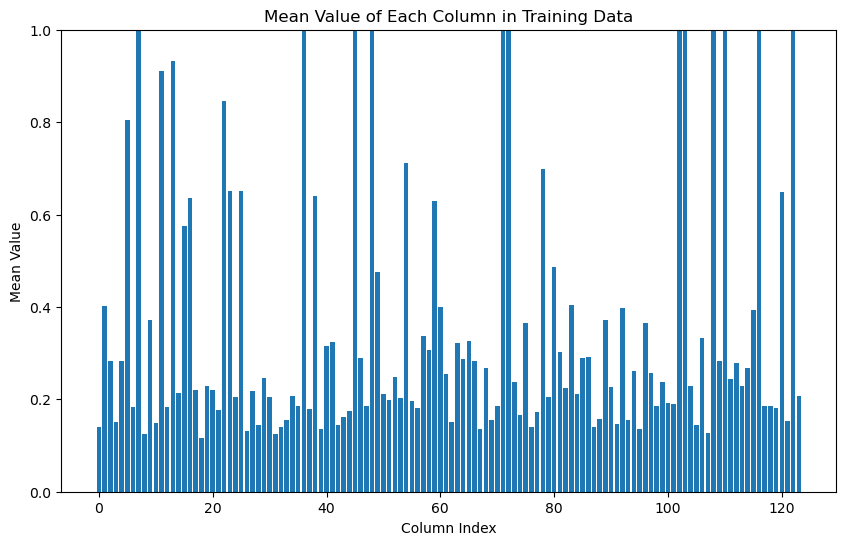

In [332]:
column_means = np.mean(X_train_filtered, axis=0)
# Plot the mean values
plt.figure(figsize=(10, 6))
plt.bar(range(len(column_means)), column_means)
plt.xlabel('Column Index')
plt.ylabel('Mean Value')
plt.ylim(0, 1)
plt.title('Mean Value of Each Column in Training Data')
plt.show()

In [333]:
ind_class0 = (y_train[:,1]==1).nonzero()[0]
print(ind_class0)
ind_class1 = (y_train[:,1]==0).nonzero()[0]
print(ind_class1)

[   4    8    9 ... 9410 9412 9418]
[   0    1    2 ... 9419 9420 9421]


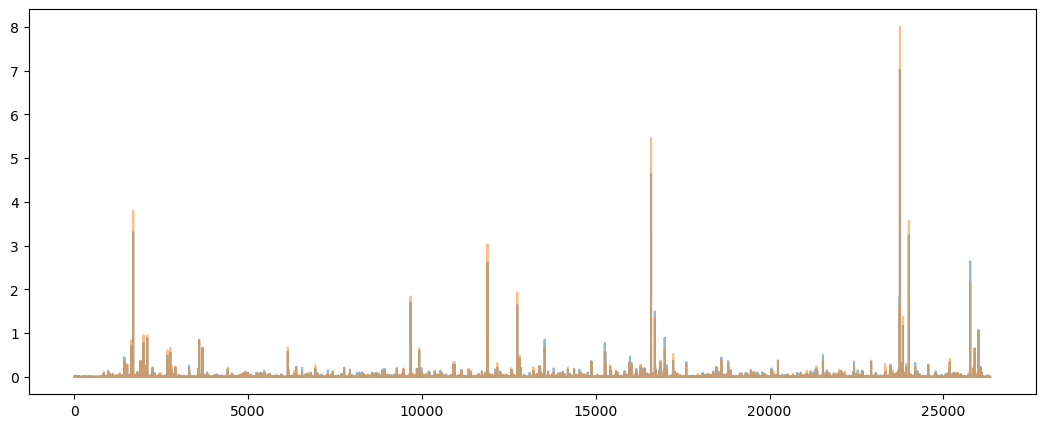

In [334]:
plt.figure(figsize=(13,5))
plt.plot(X_train[ind_class0,:].mean(axis=0),alpha=0.5)
plt.plot(X_train[ind_class1,:].mean(axis=0),alpha=0.5)
# plt.semilogy()
# plt.ylim(0.1,2)

## Identify the means of appearance of words when class 1 vs when class 0 and finding the words with the largest difference of appearances

In [335]:
# Calculate the mean appearance of each word for each class
mean_appearance_class_0 = X_train[y_train[:,1] == 0].mean(axis=0)
mean_appearance_class_1 = X_train[y_train[:,1] == 1].mean(axis=0)

# Compute the absolute difference in mean appearance between the two classes
mean_difference = np.abs(mean_appearance_class_0 - mean_appearance_class_1)

# Identify the words with the largest differences
largest_diff_indices = np.argsort(mean_difference)[::-1]  # Sort indices in descending order of difference

top_n = 30  # Number of top words to display
top_words = [vocab_data[i] for i in largest_diff_indices[:top_n]]
print(top_words)


['the', 'of', 'and', 'we', 'in', 'to', 'is', 'our', 'that', 'models', 'this', 'model', 'learning', 'neural', 'system', 'are', 'on', 'paper', 'show', 'for', 'based', 'used', 'systems', 'an', 'art', 'be', 'matrix', 'convex', 'information', 'tasks']


In [336]:
mean_difference

array([0.00029479, 0.00345295, 0.00014037, ..., 0.00028074, 0.00028074,
       0.00210556])

## Selecting how many variables to include in the ML

In [337]:
top_n = 50

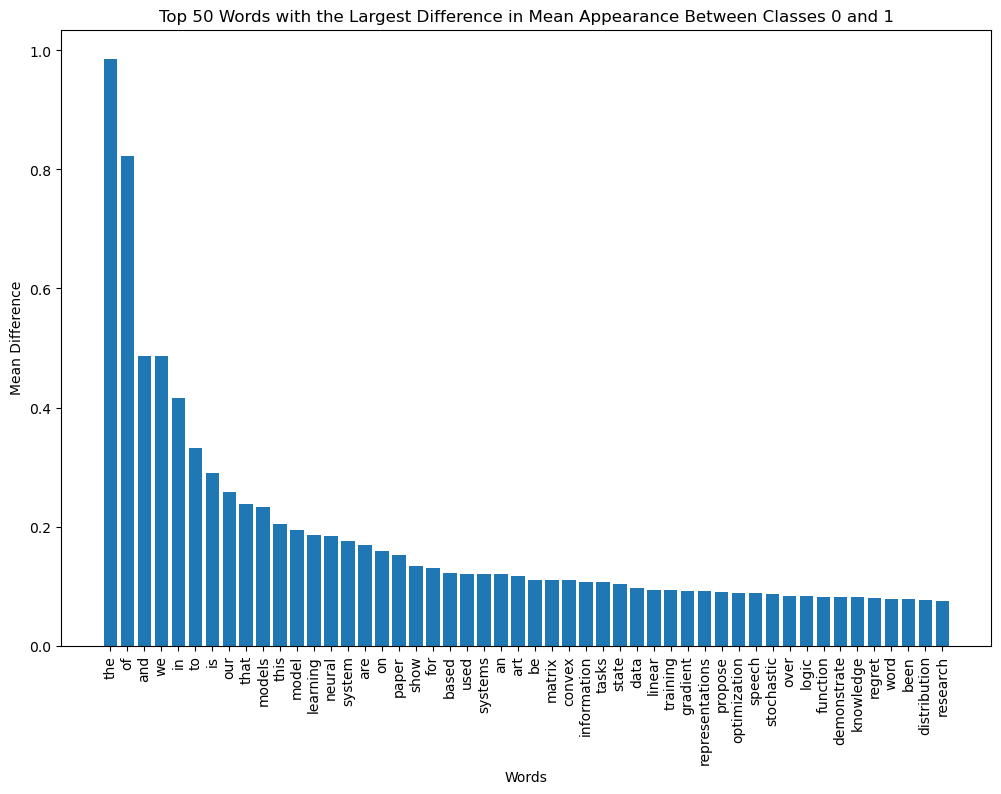

In [338]:
# Sort the mean differences and get the corresponding words
sorted_indices = np.argsort(mean_difference)[::-1]  # Sort in descending order
sorted_mean_difference = mean_difference[sorted_indices]
sorted_words = [vocab_data[i] for i in sorted_indices]



# Plot the histogram
plt.figure(figsize=(12, 8))
plt.bar(sorted_words[:top_n], sorted_mean_difference[:top_n])  # Plot top 20 words
plt.xlabel('Words')
plt.ylabel('Mean Difference')
plt.title(f'Top {top_n} Words with the Largest Difference in Mean Appearance Between Classes 0 and 1')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [339]:
top_n_indices = np.argsort(mean_difference)[-top_n:]  # Get the top n indices

# Filter X_train to only include the columns of the top n differences
X_train_filtered = X_train[:, top_n_indices]


# Train


# Evaluate the model for different numbers of top words

In [340]:
x = X_train
y = y_train[:,1]

## Accuracy


In [341]:
def topn_get_accuracy(top_n,x,y):

    #Filter the data
    top_n_indices = np.argsort(mean_difference)[-top_n:]  # Get the top n indices
    # Filter X_train to only include the columns of the top n differences
    x = x[:, top_n_indices]

    import random
    random.seed(3395)
    #Randomly choose indexes for the train and val dataset, say with 80-20 split
    num_data = x.shape[0]
    inds = list(range(num_data))
    random.shuffle(inds)
    train_inds = inds[:int(0.8*num_data)]
    val_inds = inds[int(0.8*num_data):]
    
    # Split the data into train and val sets
    train_data = x[train_inds, :]
    train_labels = y[train_inds]
    val_data = x[val_inds, :]
    val_labels = y[val_inds]
        
    iris_train1 = train_data[train_labels==0, :]
    iris_train2 = train_data[train_labels==1, :]
    
    # We create a model per class (using maximum likelihood)
    model_class1 = GaussianMaxLikelihood(top_n)
    model_class2 = GaussianMaxLikelihood(top_n)
    
    
    # We train each of them using the corresponding data
    model_class1.train(iris_train1)
    model_class2.train(iris_train2)
    
    # We create a list of all our models, and the list of prior values
    # Here the priors are calculated exactly because we know the number of representatives per class.
    model_ml = [model_class1, model_class2]
    total_num = len(iris_train1) + len(iris_train2) 
    priors = [len(iris_train1)/(total_num), len(iris_train2)/(total_num)]
    
    # We create our classifier with our list of Gaussian models and our priors
    classifier = BayesClassifier(model_ml, priors)
    
    # Calculate the log-probabilities according to our model
    log_prob = classifier.loglikelihood(train_data)
    # Predict labels
    classes_pred = log_prob.argmax(1)
    # Calculate the accuracy by comparing the predicted labels with the actual labels
    train_acc = np.mean(classes_pred == train_labels)

    # Calculate the log-probabilities according to our model
    log_prob = classifier.loglikelihood(val_data)
    # Predict labels
    classes_pred = log_prob.argmax(1)
    # Calculate the accuracy by comparing the predicted labels with the actual labels
    val_acc = np.mean(classes_pred == val_labels)


    
    return train_acc,val_acc

In [342]:
print(topn_get_accuracy(30,x,y))

(0.5242138782008757, 0.5342175066312997)


In [343]:
print(topn_get_accuracy(4,x,y))

(0.7595860421918535, 0.7421750663129973)


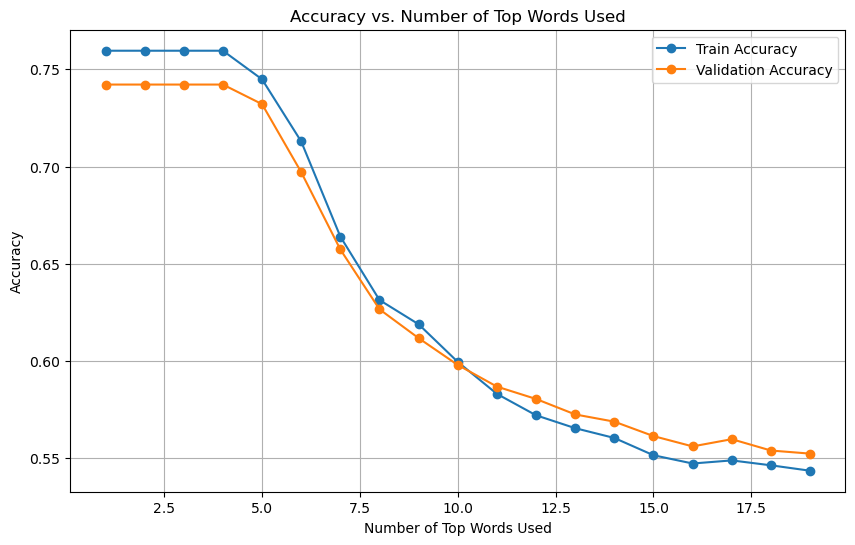

In [344]:
# Evaluate the model for different numbers of top words
top_ns = range(1, 20)  # Evaluate for top 10, 20, ..., 100 words
train_accuracies = []
val_accuracies = []

for top_n in top_ns:
    train_acc, val_acc = topn_get_accuracy(top_n, x, y)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plot the accuracy against the number of top words used
plt.figure(figsize=(10, 6))
plt.plot(top_ns, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(top_ns, val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Number of Top Words Used')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Top Words Used')
plt.legend()
plt.grid(True)
plt.show()

## Precision and recall

In [345]:
def precision_recall(y_true, y_pred):
    # Convert to NumPy arrays if they are not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    # Calculate Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (FN + TP) if (FN + TP) > 0 else 0

    return precision, recall


In [346]:
def topn_get_precision_recall(top_n,x,y):

    #Filter the data
    top_n_indices = np.argsort(mean_difference)[-top_n:]  # Get the top n indices
    # Filter X_train to only include the columns of the top n differences
    X_train_filtered = x[:, top_n_indices]

    import random
    random.seed(3395)
    #Randomly choose indexes for the train and val dataset, say with 80-20 split
    num_data = x.shape[0]
    inds = list(range(num_data))
    random.shuffle(inds)
    train_inds = inds[:int(0.8*num_data)]
    val_inds = inds[int(0.8*num_data):]
    
    # Split the data into train and val sets
    train_data = X_train_filtered[train_inds, :]
    train_labels = y[train_inds]
    val_data = X_train_filtered[val_inds, :]
    val_labels = y[val_inds]
        
    iris_train1 = train_data[train_labels==0, :]
    iris_train2 = train_data[train_labels==1, :]

    # Compute class weights
    class_weights = compute_class_weights(train_labels)
    weights_train1 = np.vectorize(class_weights.get)(train_labels[train_labels == 0])
    weights_train2 = np.vectorize(class_weights.get)(train_labels[train_labels == 1])

    
    # We create a model per class (using maximum likelihood)
    model_class1 = GaussianMaxLikelihood(top_n)
    model_class2 = GaussianMaxLikelihood(top_n)
    
    
    # We train each of them using the corresponding data and weights
    model_class1.train(iris_train1, weights=weights_train1)
    model_class2.train(iris_train2, weights=weights_train2)
    
    # We create a list of all our models, and the list of prior values
    # Here the priors are calculated exactly because we know the number of representatives per class.
    model_ml = [model_class1, model_class2]
    total_num = len(iris_train1) + len(iris_train2) 
    priors = [len(iris_train1)/(total_num), len(iris_train2)/(total_num)]
    
    # We create our classifier with our list of Gaussian models and our priors
    classifier = BayesClassifier(model_ml, priors)
    
    # Calculate the log-probabilities according to our model
    log_prob = classifier.loglikelihood(train_data)
    # Predict labels
    train_classes_pred = log_prob.argmax(1)
    train_precision,train_recall = precision_recall(train_classes_pred, train_labels)

    # Calculate the log-probabilities according to our model
    log_prob = classifier.loglikelihood(val_data)
    # Predict labels
    val_classes_pred = log_prob.argmax(1)
    val_precision,val_recall = precision_recall(val_classes_pred, val_labels)


    
    return train_precision,train_recall,val_precision,val_recall

In [347]:
topn_get_precision_recall(10,x,y)

(0.5093818984547461,
 0.3023255813953488,
 0.5164609053497943,
 0.3242894056847545)

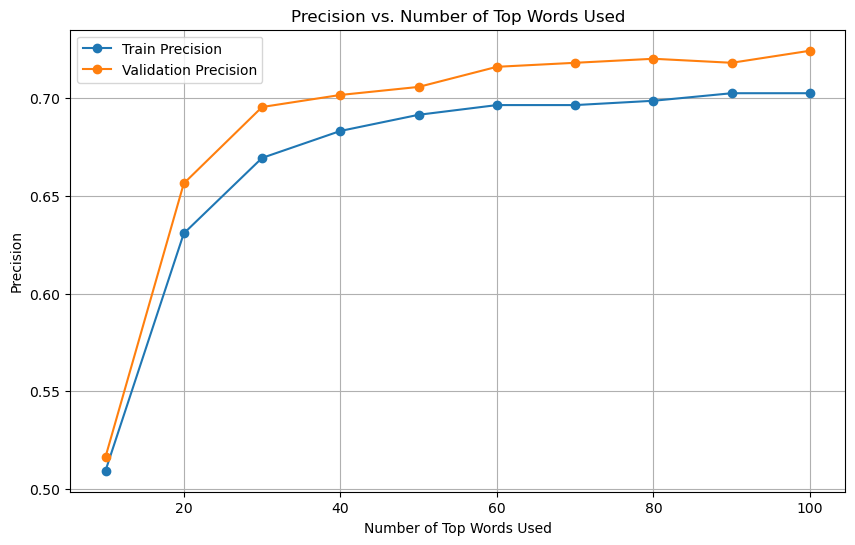

In [348]:
# Evaluate the model for different numbers of top words
top_ns = range(10, 101, 10)  # Evaluate for top 10, 20, ..., 100 words
train_precisions = []
val_precisions = []

for top_n in top_ns:
    train_prec,_, val_prec,_ = topn_get_precision_recall(top_n, x, y)
    train_precisions.append(train_prec)
    val_precisions.append(val_prec)

# Plot the precision against the number of top words used
plt.figure(figsize=(10, 6))
plt.plot(top_ns, train_precisions, marker='o', label='Train Precision')
plt.plot(top_ns, val_precisions, marker='o', label='Validation Precision')
plt.xlabel('Number of Top Words Used')
plt.ylabel('Precision')
plt.title('Precision vs. Number of Top Words Used')
plt.legend()
plt.grid(True)
plt.show()

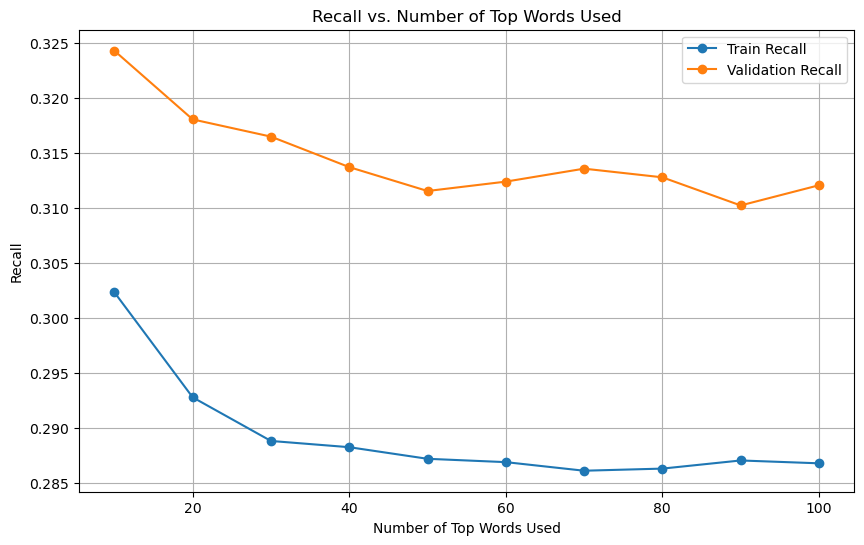

In [349]:
# Evaluate the model for different numbers of top words
top_ns = range(10, 101, 10)  # Evaluate for top 10, 20, ..., 100 words
train_recalls = []
val_recalls = []

for top_n in top_ns:
    _, train_recall, _, val_recall = topn_get_precision_recall(top_n,x,y)
    train_recalls.append(train_recall)
    val_recalls.append(val_recall)

# Plot the recall against the number of top words used
plt.figure(figsize=(10, 6))
plt.plot(top_ns, train_recalls, marker='o', label='Train Recall')
plt.plot(top_ns, val_recalls, marker='o', label='Validation Recall')
plt.xlabel('Number of Top Words Used')
plt.ylabel('Recall')
plt.title('Recall vs. Number of Top Words Used')
plt.legend()
plt.grid(True)
plt.show()

## F1 Score

In [350]:
x = X_train
y = y_train[:,1]

In [351]:
def f1_score(precision,recall):
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1_score

In [352]:
def topn_get_F1_score(top_n,x,y):

    #Filter the data
    top_n_indices = np.argsort(mean_difference)[-top_n:]  # Get the top n indices
    # Filter X_train to only include the columns of the top n differences
    x = x[:, top_n_indices]

    import random
    random.seed(3395)
    #Randomly choose indexes for the train and val dataset, say with 80-20 split
    num_data = x.shape[0]
    inds = list(range(num_data))
    random.shuffle(inds)
    train_inds = inds[:int(0.8*num_data)]
    val_inds = inds[int(0.8*num_data):]
    
    # Split the data into train and val sets
    train_data = x[train_inds, :]
    train_labels = y[train_inds]
    val_data = x[val_inds, :]
    val_labels = y[val_inds]
        
    iris_train1 = train_data[train_labels==0, :]
    iris_train2 = train_data[train_labels==1, :]
    
    # We create a model per class (using maximum likelihood)
    model_class1 = GaussianMaxLikelihood(top_n)
    model_class2 = GaussianMaxLikelihood(top_n)
    
    
    # We train each of them using the corresponding data
    model_class1.train(iris_train1)
    model_class2.train(iris_train2)
    
    # We create a list of all our models, and the list of prior values
    # Here the priors are calculated exactly because we know the number of representatives per class.
    model_ml = [model_class1, model_class2]
    total_num = len(iris_train1) + len(iris_train2) 
    priors = [len(iris_train1)/(total_num), len(iris_train2)/(total_num)]
    
    # We create our classifier with our list of Gaussian models and our priors
    classifier = BayesClassifier(model_ml, priors)
    
    # Calculate the log-probabilities according to our model
    log_prob = classifier.loglikelihood(train_data)
    # Predict labels
    train_classes_pred = log_prob.argmax(1)
    train_precision,train_recall = precision_recall(train_classes_pred, train_labels)
    train_f1_score =f1_score(train_precision,train_recall)

    # Calculate the log-probabilities according to our model
    log_prob = classifier.loglikelihood(val_data)
    # Predict labels
    val_classes_pred = log_prob.argmax(1)
    val_precision,val_recall = precision_recall(val_classes_pred, val_labels)
    val_f1_score = f1_score(val_precision,val_recall)


    
    return train_f1_score, val_f1_score

In [353]:
X_train.shape

(9422, 26354)

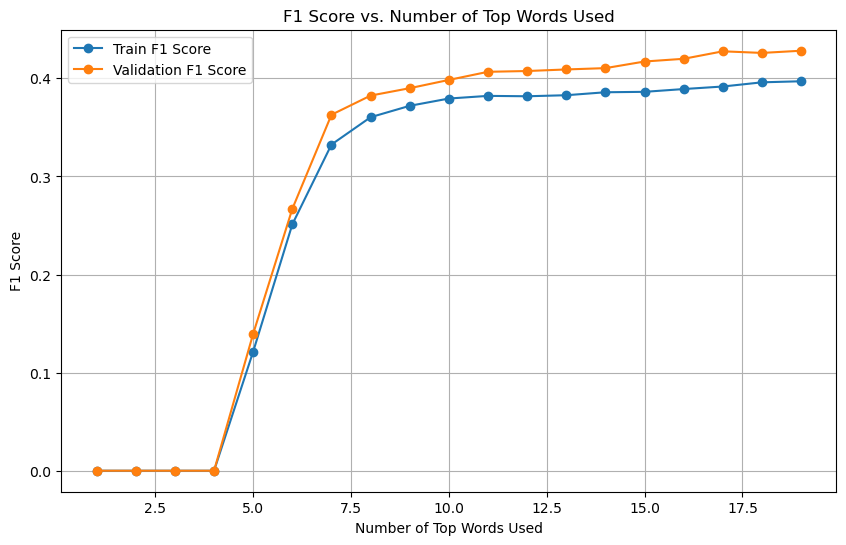

In [354]:
# Evaluate the model for different numbers of top words
top_ns = range(1, 20)  # Evaluate for top 10, 20, ..., 100 words
train_f1_scores = []
val_f1_scores = []

for top_n in top_ns:
    train_f1, val_f1 = topn_get_F1_score(top_n,x,y)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

# Plot the F1 score against the number of top words used
plt.figure(figsize=(10, 6))
plt.plot(top_ns, train_f1_scores, marker='o', label='Train F1 Score')
plt.plot(top_ns, val_f1_scores, marker='o', label='Validation F1 Score')
plt.xlabel('Number of Top Words Used')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Number of Top Words Used')
plt.legend()
plt.grid(True)
plt.show()

In [355]:
# Get the index of the max F1 score
max_f1_index = np.argmax(train_f1_scores)
print(f"Max F1 Score Index: {max_f1_index}")
print(f"Max F1 Score: {val_f1_scores[max_f1_index]}")
print(f"Max F1 Score: {max_f1_index*50+5}")

Max F1 Score Index: 18
Max F1 Score: 0.4281842818428185
Max F1 Score: 905


In [374]:
# Print class percentages for training and test datasets
print_class_percentages(y_train_pred, "Training prediction Dataset")
# Print class percentages for training and test datasets
print_class_percentages(y_train, "Training Dataset")

Class percentages for Training prediction Dataset:
Class 0.0: 56.84%
Class 1.0: 43.16%
Class percentages for Training Dataset:
Class 0.0: 75.73%
Class 1.0: 24.27%


# Get predictions

In [357]:
def topn_get_prediction(top_n,x_train,y_train,x_test):

    #Filter the data
    top_n_indices = np.argsort(mean_difference)[-top_n:]  # Get the top n indices
    # Filter X_train to only include the columns of the top n differences
    x_test = X_train[:, top_n_indices]
    x_filtered_test = X_test[:, top_n_indices]

    import random
    random.seed(3395)
    #Randomly choose indexes for the train and val dataset, say with 80-20 split
    num_data = x.shape[0]
    inds = list(range(num_data))
    random.shuffle(inds)
    train_inds = inds[:int(0.8*num_data)]
    val_inds = inds[int(0.8*num_data):]
    
    # Split the data into train and val sets
    train_data = x_test[train_inds, :]
    train_labels = y[train_inds]
    val_data = x_test[val_inds, :]
    val_labels = y[val_inds]
        
    iris_train1 = train_data[train_labels==0, :]
    iris_train2 = train_data[train_labels==1, :]
    
    # We create a model per class (using maximum likelihood)
    model_class1 = GaussianMaxLikelihood(top_n)
    model_class2 = GaussianMaxLikelihood(top_n)
    
    
    # We train each of them using the corresponding data
    model_class1.train(iris_train1)
    model_class2.train(iris_train2)
    
    # We create a list of all our models, and the list of prior values
    # Here the priors are calculated exactly because we know the number of representatives per class.
    model_ml = [model_class1, model_class2]
    total_num = len(iris_train1) + len(iris_train2) 
    priors = [len(iris_train1)/(total_num), len(iris_train2)/(total_num)]
    
    # We create our classifier with our list of Gaussian models and our priors
    classifier = BayesClassifier(model_ml, priors)
    
    # Calculate the log-probabilities according to our model
    log_prob = classifier.loglikelihood(x_filtered_test)
    # Predict labels
    classes_pred = log_prob.argmax(1)





    
    return classes_pred

In [358]:
milestone1 = topn_get_prediction(170,X_train,y,X_test)


In [359]:
import pandas as pd
import os as os

In [360]:
def save_array_with_index(array, filename):
    # Create a DataFrame with the array
    df = pd.DataFrame(array, columns=['label'])
    
    # Add the 'id' column using the row index
    df['ID'] = df.index
    
    # Reorder the columns to have 'id' first and 'label' second
    df = df[['ID', 'label']]
    
    # Check if the file exists and save over it
    if os.path.exists(filename):
        print(f"File {filename} exists. Saving over it.")
    else:
        print(f"File {filename} does not exist. Creating a new file.")
    
    # Save the DataFrame as a CSV file
    df.to_csv(filename, index=False)

# Test

In [361]:
top_n = 355
#Filter the data
top_n_indices = np.argsort(mean_difference)[-top_n:]  # Get the top n indices
# Filter X_train to only include the columns of the top n differences
x = X_train[:, top_n_indices]
y = y_train[:,1]

x_test_filtered = X_test[:, top_n_indices]

In [362]:
y.shape

(9422,)

In [363]:
x.shape

(9422, 355)

In [364]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight




# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x,y, test_size=0.2, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Fit the model
gnb.fit(X_train, y_train)

# Predict on the validation set
y_train_pred = gnb.predict(X_train)

# Predict on the validation set
y_val_pred = gnb.predict(X_val)

#predict on test set

y_test_pred = gnb.predict(x_test_filtered)

# Calculate F1 score
f1_train= f1_score(y_val, y_val_pred, average='macro')
print(f"Macro F1 Score train: {f1_train}")

# Calculate F1 score
f1 = f1_score(y_train, y_train_pred, average='macro')
print(f"Macro F1 Score: {f1}")



Macro F1 Score train: 0.6769922605382122
Macro F1 Score: 0.6728680071172246


In [365]:
filename = 'prediction_milestone1.csv'

save_array_with_index(y_test_pred, filename)

File prediction_milestone1.csv exists. Saving over it.


In [371]:
def save_txt(array):
    # Create an array of indices
    indices = np.arange(array.shape[0]).reshape(-1, 1)
    
    # Concatenate the indices with the original array
    array_with_indices = np.hstack((indices, array.reshape(-1, 1)))
    
    # Print the result
    print(array_with_indices)
    
    np.savetxt('predictions_milestone1.txt',array_with_indices,header='ID , label',delimiter=',',fmt='%d')
    print("Saved")

In [372]:
save_txt(y_test_pred)

[[0.000e+00 0.000e+00]
 [1.000e+00 0.000e+00]
 [2.000e+00 0.000e+00]
 ...
 [2.353e+03 0.000e+00]
 [2.354e+03 0.000e+00]
 [2.355e+03 1.000e+00]]
Saved


In [368]:
y_test_pred

array([0., 0., 0., ..., 0., 0., 1.])

In [373]:
filename = 'prediction_milestone1.csv'

save_array_with_index(y_test_pred, filename)

File prediction_milestone1.csv exists. Saving over it.
